In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.patches as patches
import matplotlib.colors
import cartopy
import numpy as np

In [2]:
name = 'crps'
ecmwf_sum = xr.open_dataset("ecmwf_"+name+"_2012.nc")
for year in np.array([2013, 2014, 2015, 2016, 2017,2018, 2019]):
    ecmwf = xr.open_dataset("ecmwf_"+name+"_"+str(year)+".nc")
    ecmwf_sum = ecmwf + ecmwf_sum 
    ecmwf.close()
ecmwf_sum = ecmwf_sum / 8

In [3]:
name = 'crps'
epc_sum = xr.open_dataset("EPC15_"+name+"_2012.nc")
for year in np.array([2013, 2014, 2015, 2016, 2017,2018, 2019]):
    epc = xr.open_dataset("EPC15_"+name+"_"+str(year)+".nc")
    epc_sum = epc + epc_sum
    epc.close()
epc_sum = epc_sum / 8

In [9]:
# mean over time and space
print('ecmwf mean:', np.round(ecmwf_sum.mean()['var'].values, 2))
print('epc15 mean:', np.round(epc_sum.mean()['var'].values, 2))

ecmwf mean: 2.21
epc15 mean: 2.59


In [10]:
# mean over space for year 2012, 2013, ..., 2019 respectively
ecmwf_year_mean = []
name = 'crps'
ecmwf = xr.open_dataset("ecmwf_"+name+"_2012.nc")
ecmwf_year_mean.append(ecmwf.mean()['var'].values)
ecmwf.close()
for year in np.array([2013, 2014, 2015, 2016, 2017,2018, 2019]):
    ecmwf = xr.open_dataset("ecmwf_"+name+"_"+str(year)+".nc")
    ecmwf_year_mean.append(ecmwf.mean()['var'].values)
    ecmwf.close()
print(np.asarray(ecmwf_year_mean))

[2.3818272  2.38811656 2.24190565 2.17651456 2.10275998 2.11911408
 2.12945887 2.13036852]


In [11]:
# mean over space for year 2012, 2013, ..., 2019 respectively
epc_year_mean = []
name = 'crps'
epc = xr.open_dataset("EPC15_"+name+"_2012.nc")
epc_year_mean.append(epc.mean()['var'].values)
epc.close()
for year in np.array([2013, 2014, 2015, 2016, 2017,2018, 2019]):
    epc = xr.open_dataset("EPC15_"+name+"_"+str(year)+".nc")
    epc_year_mean.append(epc.mean()['var'].values)
    epc.close()
print(np.asarray(epc_year_mean))

[2.69627189 2.70910023 2.62057491 2.6361834  2.59051165 2.50403928
 2.48510695 2.49957324]


In [12]:
# plot of crpss of ecmwf
crpss = (epc_sum - ecmwf_sum) / epc_sum
crpss_val = crpss['var'].values
lon = epc_sum.lon.values
lat = epc_sum.lat.values

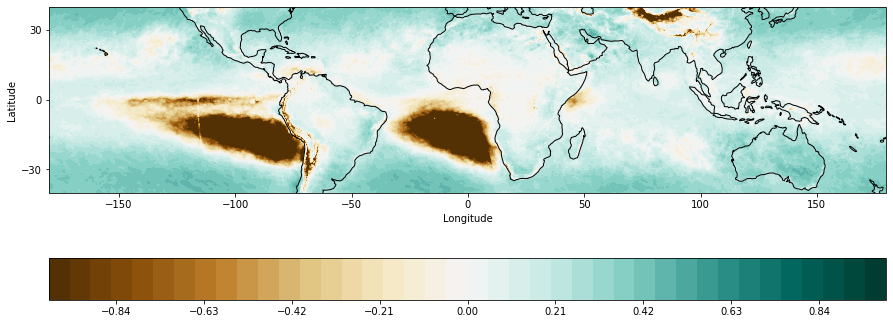

In [16]:
crpss_val_trans = np.where(crpss_val > 1, 1, crpss_val)
crpss_val_trans = np.where(crpss_val_trans < -1, -1, crpss_val_trans)

col_gradient = cm.get_cmap('BrBG', 40)
newcolors = col_gradient(np.linspace(0, 1, 40))
newcmp = ListedColormap(newcolors)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,8), gridspec_kw={'height_ratios': [3, 1]})
ax1 = plt.axes(projection=ccrs.PlateCarree())

cf = plt.contourf(lon, lat,crpss_val_trans,np.arange(-1, 1.01,0.01),cmap=newcmp) 
                 
ax1.coastlines()

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
yt = ax1.set_yticks([-30, 0,30])
xt = ax1.set_xticks([-150,-100,-50, 0, 50, 100,150])

cb = fig.colorbar(cf,orientation='horizontal')

In [21]:
# CRPS averaged over specific regions
lat = ecmwf_sum.lat.values
lon = ecmwf_sum.lon.values

# 1. South America
southAmlat = lat[110:203]
southAmlon = lon[390:511]
# 2. Central Africa
midAlat =lat[140:233]
midAlon = lon[650:885]
# 3. India
indialat = lat[188:281]
indialon = lon[996:1073]
# 4. Australia
australialat = lat[0:121]
australialon = lon[1274:1341]
# 5. South-east asia
asialat = lat[120:257]
asialon = lon[1090:1230]

text = np.array(['south america', 'central africa', 'india', 'australia', 'south-east asia'])

all_lat = []
all_lon = []
all_lat.append(southAmlat)
all_lat.append(midAlat)
all_lat.append(indialat)
all_lat.append(australialat)
all_lat.append(asialat)
all_lat.append(statlat)
all_lon.append(southAmlon)
all_lon.append(midAlon)
all_lon.append(indialon)
all_lon.append(australialon)
all_lon.append(asialon)
all_lon.append(statlon)
for i in range(5):
    lats_sel = all_lat[i]
    lons_sel = all_lon[i]
    epc_sel = epc_sum.sel(lat = lats_sel)
    epc_sel = epc_sel.sel(lon =lons_sel)

    ecmwf_sel = ecmwf_sum.sel(lat = lats_sel)
    ecmwf_sel = ecmwf_sel.sel(lon =lons_sel)
    print(text[i])
    print('ecmwf:', np.round(ecmwf_sel.mean()['var'].values,2))
    print('epc:', np.round(epc_sel.mean()['var'].values,2))
    

south america
ecmwf: 4.04
epc: 3.99
central africa
ecmwf: 2.36
epc: 2.25
india
ecmwf: 2.43
epc: 2.76
australia
ecmwf: 1.54
epc: 2.0
south-east asia
ecmwf: 4.35
epc: 4.78
